In [87]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from e6dataflow.datamodel import load_datamodel, get_datamodel
from e6dataflow.tools.fittools import e6_fit
from scipy.optimize import curve_fit
import colorsys

import e6py.smart_gaussian2d_fit as e6fit
from e6dataflow.utils import make_centered_roi

In [88]:
### Load datamodel from .p file
run_name = 'run1'

datamodel = load_datamodel(datamodel_path=Path.cwd(), run_name=run_name)

Loading datamodel from C:\Users\Emma\Desktop\analysis\2021\02\14\run1\run1-datamodel.p


In [89]:
### Information about run:

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = len(tweezer_freq_list)

probe_att_list = [0.1,3,6,9]
pzt_para_list = [5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]

num_points = datamodel.num_points #len(pzt_para_list) * len(probe_att_list)

tweezer_freq_list = [108,110,112,114,116]
num_tweezers = 5 #len(tweezer_freq_list)

mol_freq_list = [4.5,5,5.5,6,6.5,7,7.5,8]
num_frames = 10 #len(mol_freq_list) + 2

num_shots = datamodel.num_shots

num_loops = num_shots // num_points

print(num_points,'points')
print(num_frames,'frames')
print(num_tweezers,'tweezers')
print(num_shots,'shots')
print(num_loops,'complete loops')


t_exposure = 500

t_hold_1 = 100
t_hold_2 = 1000
t_hold_3 = 10000
t_frame_1 = t_exposure + t_hold_1
t_frame_2 = t_exposure + t_hold_2
t_frame_3 = t_exposure + t_hold_3

roi_width = 14
roi_height = 12
roi_area = roi_width * roi_width

40 points
10 frames
5 tweezers
1000 shots
25 complete loops


In [98]:
a = 0
b='test'

In [97]:
f'frame-{a:02d}_{b}'

'frame-00_test'

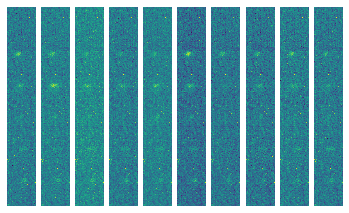

In [91]:
for i in range(10):
    f = datamodel.get_data('frame-05_avg',i)['mean']
    plt.subplot(1,10,i+1)
    plt.imshow(f)
    plt.axis('off')

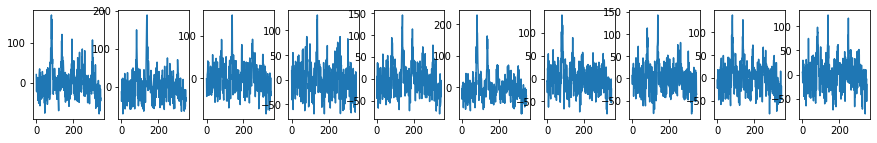

In [109]:
a = []
plt.figure(figsize=[15,2])
for i in range(10):
    f = datamodel.get_data('frame-05_avg',i)['mean']
    plt.subplot(1,10,i+1)
    a.append(np.sum(f,1)-np.mean(np.sum(f,1)))
    plt.plot(a[i])

In [95]:
f[a]

array([[121.36, 118.56, 117.4 , 117.96, 116.68, 116.56, 113.4 , 112.64,
        119.  , 114.44, 114.16, 111.88, 118.88, 117.32, 110.32, 114.92,
        119.88, 114.36, 119.48, 113.32],
       [111.88, 112.24, 111.64, 117.68, 116.76, 116.96, 114.76, 112.44,
        108.8 , 113.48, 113.24, 115.36, 112.24, 112.84, 112.72, 110.08,
        114.52, 116.44, 113.  , 113.04],
       [112.72, 114.68, 114.24, 115.32, 109.72, 117.6 , 109.88, 115.56,
        119.04, 116.72, 112.04, 115.84, 114.92, 116.52, 118.  , 117.8 ,
        105.92, 115.4 , 113.96, 109.4 ],
       [111.08, 113.88, 116.72, 120.24, 115.4 , 118.28, 116.12, 119.  ,
        109.84, 113.96, 117.44, 116.52, 116.44, 110.72, 115.16, 111.8 ,
        108.44, 114.04, 114.24, 115.64],
       [115.24, 111.88, 120.88, 112.16, 117.4 , 114.8 , 112.96, 110.68,
        112.8 , 114.76, 112.84, 110.36, 117.4 , 114.  , 121.2 , 113.32,
        111.96, 116.92, 119.56, 111.84],
       [118.28, 115.8 , 118.56, 106.68, 116.72, 112.72, 114.84, 119.04,
   

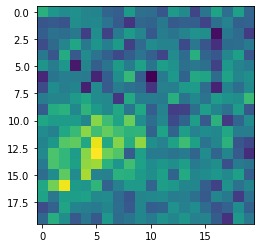

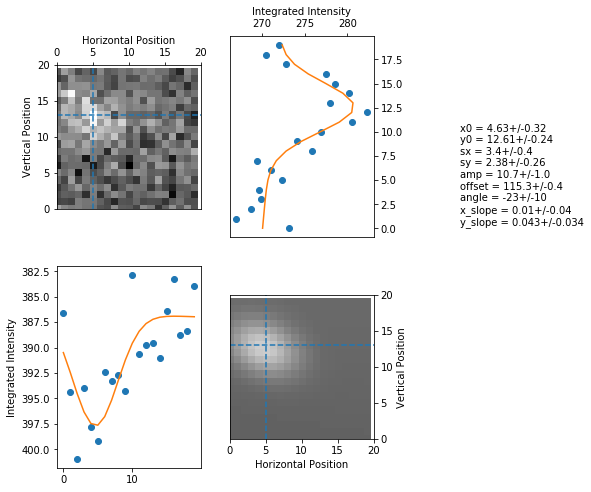

In [92]:
a = make_centered_roi(vert_center=80,horiz_center=25,vert_span=20,horiz_span=20)
plt.imshow(f[a])
fit_struct = e6fit.fit_gaussian2d(f[a])

In [11]:
tweezer_00_vert_center = 81.15# starting position of tweezer 0 = 108MHz
tweezer_00_horiz_center = 21.2
tweezer_horiz_span = 20
tweezer_vert_span = 14

tweezer_vert_spacing = 27.8*2 #2 is freq diff between neighboring tweezers on this run
tweezer_horiz_spacing = 1.3867*2

piezo_vert_shift = 0.3*0.5  #0.5 is step size of pzt_para_list on this run
piezo_horiz_shift = 1.4*0.5

In [12]:
roi_guess_array = np.zeros([num_points, num_tweezers], dtype=object)

for tweezer_num in range(num_tweezers):
    for point_num in range(num_points):
        v_center = tweezer_00_vert_center + tweezer_num * tweezer_vert_spacing \
                    + point_num//4*piezo_vert_shift
        h_center = tweezer_00_horiz_center + tweezer_num * tweezer_horiz_spacing \
                    + point_num//4*piezo_horiz_shift
        roi_guess_array[point_num, tweezer_num] = \
                    make_centered_roi(vert_center=v_center,
                                        horiz_center=h_center,
                                        vert_span=tweezer_vert_span,
                                        horiz_span=tweezer_horiz_span)

What do I want? We have an aggregator that creates the average frames. 
I guess I want a "point processor" that takes the avg frames from the point_data dict and performs a fit, using an roi_guess_array or better yet, atom_position_guess_array. 
It should do the fit and save the fit results. 
Then a reporter should plot the ROIs on the avg frame. 
THEN the datamodel can start with the auto ROIs selected. 

In [37]:
import time

(slice(74, 88, 1), slice(11, 31, 1))


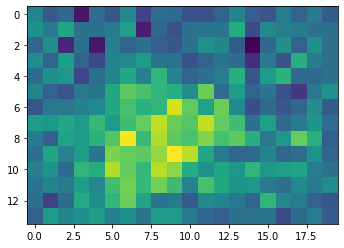

(slice(129, 143, 1), slice(13, 33, 1))


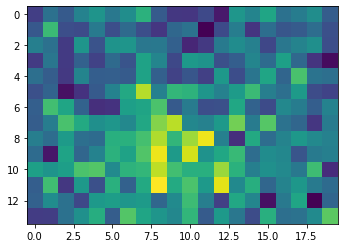

(slice(185, 199, 1), slice(16, 36, 1))


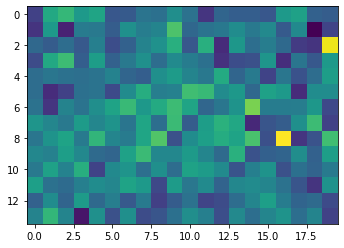

(slice(240, 254, 1), slice(19, 39, 1))


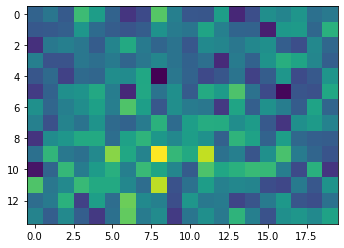

(slice(296, 310, 1), slice(22, 42, 1))


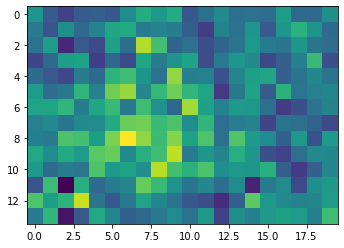

In [41]:
for roi in roi_guess_array[0,:]:
    print(roi)
    plt.imshow(f[roi])
    plt.show()

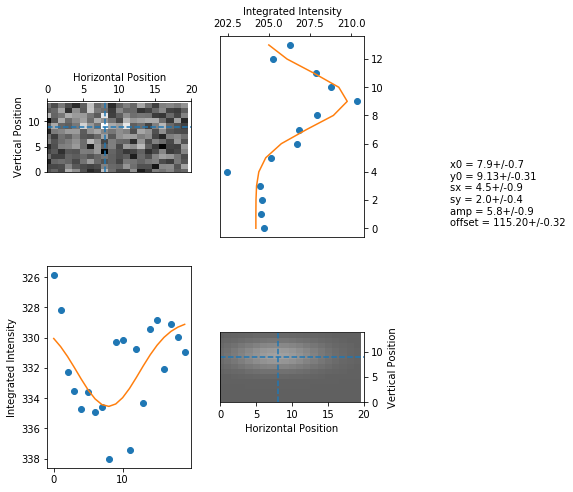

In [46]:
fit_struct = e6fit.fit_gaussian2d(f[roi_guess_array[0,3]],fix_angle=True,fix_lin_slope=True)

In [67]:
roi_guess_array[0,3][0].stop-roi_guess_array[0,3][0].start

14

In [62]:
roi_guess_array[0,3][0]+int(fit_struct['y0']['val']-tweezer_vert_span/2)

TypeError: unsupported operand type(s) for +: 'slice' and 'int'

In [50]:
make_centered_roi(vert_center=roi_guess_array[0,3][0].start+fit_struct['y0']['val'],\
                                                      horiz_center=roi_guess_array[0,3][1].start+fit_struct['x0']['val'],\
                                                      vert_span=tweezer_vert_span,\
                                                      horiz_span=tweezer_horiz_span)

(slice(242, 256, 1), slice(16, 36, 1))

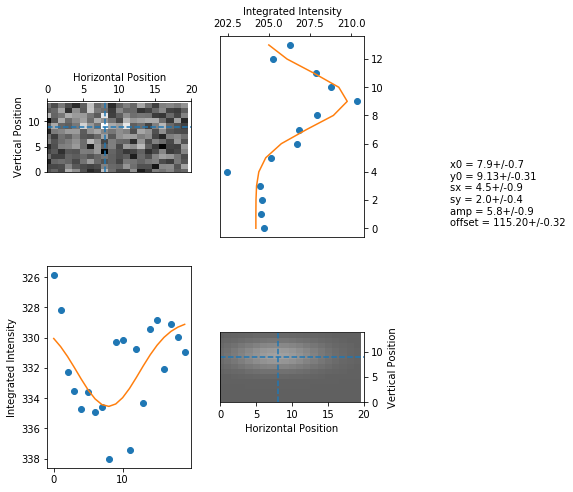

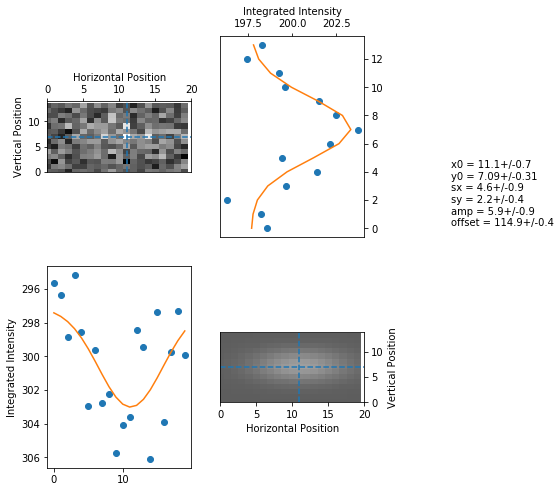

In [52]:
fit_struct = e6fit.fit_gaussian2d(f[roi_guess_array[0,3]],fix_angle=True,fix_lin_slope=True)
fit_struct2 = e6fit.fit_gaussian2d(f[make_centered_roi(vert_center=roi_guess_array[0,3][0].start+fit_struct['y0']['val'],\
                                                      horiz_center=roi_guess_array[0,3][1].start+fit_struct['x0']['val'],\
                                                      vert_span=tweezer_vert_span,\
                                                      horiz_span=tweezer_horiz_span)],\
                                  fix_angle=True,fix_lin_slope=True)

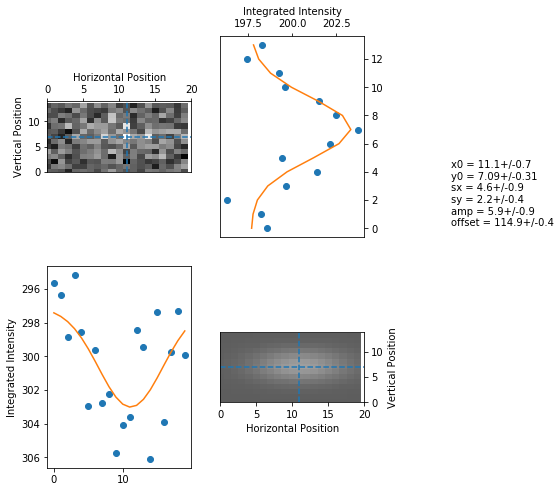

In [18]:
fit_struct2['fit_fig']